<a href="https://colab.research.google.com/github/riszwinger/tensorflow_cert/blob/main/basic/ImageAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np

import os
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import RMSprop

## Download data

In [2]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2021-08-09 11:36:28--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  52.3MB/s    in 1.3s    

2021-08-09 11:36:30 (52.3 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
!ls /tmp

cats_and_dogs_filtered.zip
dap_multiplexer.415341ac6796.root.log.INFO.20210809-113143.52
dap_multiplexer.INFO
debugger_2fm3bcjt0s
initgoogle_syslog_dir.0


## Unzip

In [4]:
local_zip="/tmp/cats_and_dogs_filtered.zip"
zipref=zipfile.ZipFile(local_zip,'r')
zipref.extractall('/tmp/')
zipref.close()

In [5]:
!ls /tmp/cats_and_dogs_filtered

train  validation  vectorize.py


In [6]:
train_dir="/tmp/cats_and_dogs_filtered/train"
val_dir="/tmp/cats_and_dogs_filtered/validation"

In [7]:
print('Training cats: {}, Training Dogs: {}'.format(len(os.listdir(os.path.join(train_dir,'cats'))),len(os.listdir(os.path.join(train_dir,'dogs')))))
print('Validation cats: {}, Validation Dogs: {}'.format(len(os.listdir(os.path.join(val_dir,'cats'))),len(os.listdir(os.path.join(val_dir,'dogs')))))

Training cats: 1000, Training Dogs: 1000
Validation cats: 500, Validation Dogs: 500


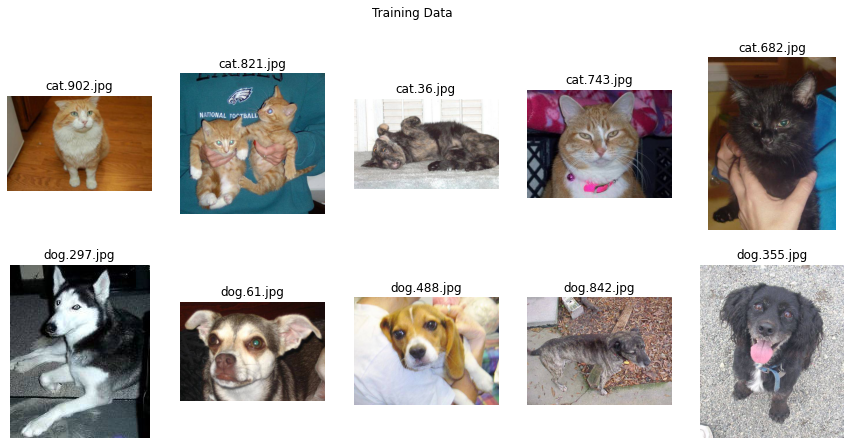

****************************************************************************************************


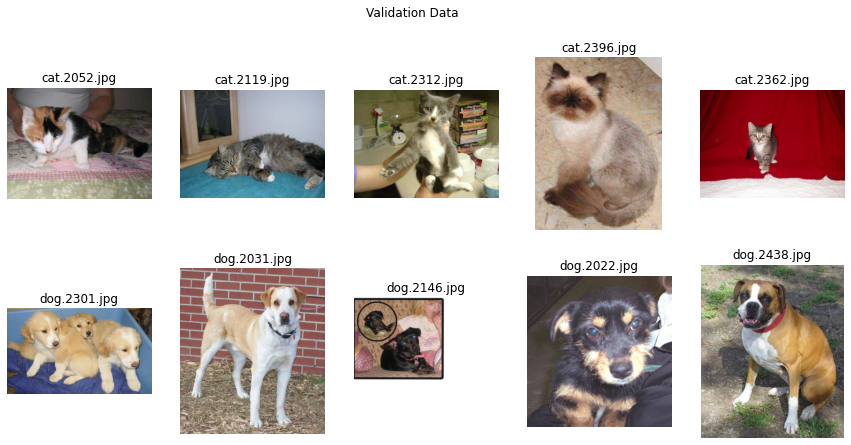

In [8]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def visualize_data(labels, dir, title):
    """
    Uses matplotlib to visualize PIL images
    :param labels (list) :  list of labels eg: ['cats','dogs']
    :param dir: path of files with labels as subfolders
    :param title: title of the plot
    :return: visualize 5 images from each label randomly
    """
    # labels=['horses','humans']
    num_class = len(labels)
    # train_dir="/tmp/horse-or-human/"
    fig, ax = plt.subplots(num_class, 5, figsize=(15, 7))
    for i in range(num_class):
        for j in range(5):
            img_list = (os.listdir(os.path.join(dir, labels[i])))
            img = img_list[random.randint(0, len(img_list))]
            ax[i, j].imshow(mpimg.imread(os.path.join(dir, labels[i], img)))
            ax[i, j].set_title(img)
            ax[i, j].axis('off')
    plt.suptitle(title)
    plt.show()


# Example
labels=['cats','dogs']
dir=train_dir
title='Training Data'
visualize_data(labels,dir,title)
print("*"*100)
dir=val_dir
title='Validation Data'
visualize_data(labels,dir,title)

## Image Augmentation

In [9]:
train_datagen=ImageDataGenerator(rescale=1./255,width_shift_range=0.2, height_shift_range=0.2,horizontal_flip=True,fill_mode='nearest',rotation_range=40,shear_range=0.2,
        zoom_range=0.2)
valid_datagen=ImageDataGenerator(rescale=1./255)

In [10]:
train_generator=train_datagen.flow_from_directory(train_dir,target_size=(150,150),class_mode='binary',batch_size=100)
val_generator=valid_datagen.flow_from_directory(val_dir,target_size=(150,150),class_mode='binary',batch_size=100)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Model Building-1

In [11]:
model=Sequential(name='SEQ_1')
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(150,150,3),name='Layer_1_CONV'))
model.add(MaxPool2D((2,2),name='Layer_2_MaxPool'))

model.add(Conv2D(32,(3,3),activation='relu',name='Layer_3_CONV'))
model.add(MaxPool2D((2,2),name='Layer_4_MaxPool'))

model.add(Conv2D(64,(3,3),activation='relu',name='Layer_5_CONV'))
model.add(MaxPool2D((2,2),name='Layer_6_MaxPool'))

model.add(Flatten(name='Layer_7_Flatten'))
model.add(Dense(128,activation='relu',name='Layer_8_Dense'))
model.add(Dense(1,activation='sigmoid',name='last_layer_Dense'))
model.summary()


Model: "SEQ_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_1_CONV (Conv2D)        (None, 148, 148, 16)      448       
_________________________________________________________________
Layer_2_MaxPool (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
Layer_3_CONV (Conv2D)        (None, 72, 72, 32)        4640      
_________________________________________________________________
Layer_4_MaxPool (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
Layer_5_CONV (Conv2D)        (None, 34, 34, 64)        18496     
_________________________________________________________________
Layer_6_MaxPool (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
Layer_7_Flatten (Flatten)    (None, 18496)             0     

In [12]:
model.compile(optimizer=RMSprop(learning_rate=0.001),loss='binary_crossentropy',metrics=['acc'])

In [13]:
steps_per_epoch=2000/100
validation_steps=1000/100
print('steps_per_epoch: {}, validation_steps: {}'.format(steps_per_epoch,validation_steps))

steps_per_epoch: 20.0, validation_steps: 10.0


In [14]:
history=model.fit(train_generator,steps_per_epoch=steps_per_epoch,epochs=10,validation_data=val_generator,validation_steps=validation_steps)

Epoch 1/10
20/20 [==============================] - 49s 941ms/step - loss: 0.8551 - acc: 0.5095 - val_loss: 0.6850 - val_acc: 0.5940
Epoch 2/10
20/20 [==============================] - 19s 964ms/step - loss: 0.6922 - acc: 0.5235 - val_loss: 0.7564 - val_acc: 0.5000
Epoch 3/10
20/20 [==============================] - 19s 954ms/step - loss: 0.6862 - acc: 0.5520 - val_loss: 0.6835 - val_acc: 0.5200
Epoch 4/10
20/20 [==============================] - 19s 951ms/step - loss: 0.6830 - acc: 0.5570 - val_loss: 0.6456 - val_acc: 0.6120
Epoch 5/10
20/20 [==============================] - 19s 946ms/step - loss: 0.6665 - acc: 0.6000 - val_loss: 0.6260 - val_acc: 0.6540
Epoch 6/10
20/20 [==============================] - 19s 963ms/step - loss: 0.6497 - acc: 0.6280 - val_loss: 0.6161 - val_acc: 0.6600
Epoch 7/10
20/20 [==============================] - 19s 948ms/step - loss: 0.6322 - acc: 0.6490 - val_loss: 0.6321 - val_acc: 0.6160
Epoch 8/10
20/20 [==============================] - 19s 969ms/step - 

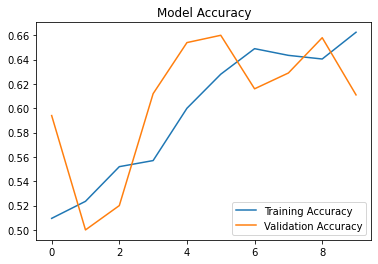

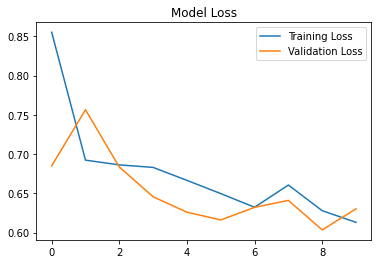

In [15]:
train_acc=history.history['acc']
val_acc=history.history['val_acc']
epochs=range(len(train_acc))
plt.plot(epochs,train_acc,label='Training Accuracy')
plt.plot(epochs,val_acc,label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.figure()

train_loss=history.history['loss']
val_loss=history.history['val_loss']
plt.plot(epochs,train_loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

## Model -2

In [16]:
model2=Sequential(name='SEQ_2')
model2.add(Conv2D(16,(3,3),activation='relu',input_shape=(150,150,3),name='Layer_1_CONV'))
model2.add(MaxPool2D((2,2),name='Layer_2_MaxPool'))

model2.add(Conv2D(32,(3,3),activation='relu',name='Layer_3_CONV'))
model2.add(MaxPool2D((2,2),name='Layer_4_MaxPool'))

model2.add(Conv2D(64,(3,3),activation='relu',name='Layer_5_CONV'))
model2.add(MaxPool2D((2,2),name='Layer_6_MaxPool'))

model2.add(Conv2D(128,(3,3),activation='relu',name='Layer_7_CONV'))
model2.add(MaxPool2D((2,2),name='Layer_8_MaxPool'))

model2.add(Flatten(name='Layer_9_Flatten'))
model2.add(Dense(512,activation='relu',name='Layer_10_Dense'))
model2.add(Dense(1,activation='sigmoid',name='last_layer_Dense'))
model2.summary()


Model: "SEQ_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_1_CONV (Conv2D)        (None, 148, 148, 16)      448       
_________________________________________________________________
Layer_2_MaxPool (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
Layer_3_CONV (Conv2D)        (None, 72, 72, 32)        4640      
_________________________________________________________________
Layer_4_MaxPool (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
Layer_5_CONV (Conv2D)        (None, 34, 34, 64)        18496     
_________________________________________________________________
Layer_6_MaxPool (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
Layer_7_CONV (Conv2D)        (None, 15, 15, 128)       73856 

In [17]:
model2.compile(optimizer=RMSprop(learning_rate=0.001),loss='binary_crossentropy',metrics=['acc'])
history=model2.fit(train_generator,steps_per_epoch=steps_per_epoch,epochs=10,validation_data=val_generator,validation_steps=validation_steps)

Epoch 1/10
20/20 [==============================] - 21s 987ms/step - loss: 0.7983 - acc: 0.5040 - val_loss: 0.6902 - val_acc: 0.5000
Epoch 2/10
20/20 [==============================] - 19s 953ms/step - loss: 0.6917 - acc: 0.5265 - val_loss: 0.8331 - val_acc: 0.5000
Epoch 3/10
20/20 [==============================] - 19s 955ms/step - loss: 0.6949 - acc: 0.5430 - val_loss: 0.6834 - val_acc: 0.5110
Epoch 4/10
20/20 [==============================] - 19s 948ms/step - loss: 0.6766 - acc: 0.5705 - val_loss: 0.6504 - val_acc: 0.6300
Epoch 5/10
20/20 [==============================] - 19s 955ms/step - loss: 0.6931 - acc: 0.5860 - val_loss: 0.6526 - val_acc: 0.6240
Epoch 6/10
20/20 [==============================] - 19s 947ms/step - loss: 0.6681 - acc: 0.6040 - val_loss: 0.6531 - val_acc: 0.5810
Epoch 7/10
20/20 [==============================] - 19s 942ms/step - loss: 0.6662 - acc: 0.6000 - val_loss: 0.6545 - val_acc: 0.5730
Epoch 8/10
20/20 [==============================] - 19s 956ms/step - 

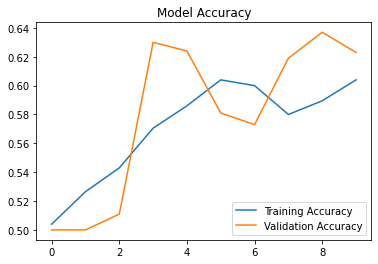

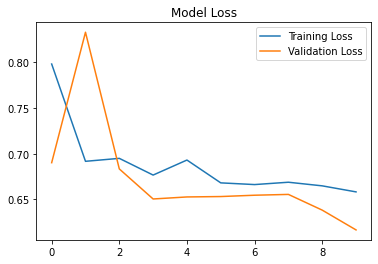

In [18]:
train_acc=history.history['acc']
val_acc=history.history['val_acc']
epochs=range(len(train_acc))
plt.plot(epochs,train_acc,label='Training Accuracy')
plt.plot(epochs,val_acc,label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.figure()

train_loss=history.history['loss']
val_loss=history.history['val_loss']
plt.plot(epochs,train_loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

## Increasing epochs to 30

In [19]:
model3=Sequential(name='SEQ_2')
model3.add(Conv2D(16,(3,3),activation='relu',input_shape=(150,150,3),name='Layer_1_CONV'))
model3.add(MaxPool2D((2,2),name='Layer_2_MaxPool'))

model3.add(Conv2D(32,(3,3),activation='relu',name='Layer_3_CONV'))
model3.add(MaxPool2D((2,2),name='Layer_4_MaxPool'))

model3.add(Conv2D(64,(3,3),activation='relu',name='Layer_5_CONV'))
model3.add(MaxPool2D((2,2),name='Layer_6_MaxPool'))

model3.add(Conv2D(128,(3,3),activation='relu',name='Layer_7_CONV'))
model3.add(MaxPool2D((2,2),name='Layer_8_MaxPool'))

model3.add(Flatten(name='Layer_9_Flatten'))
model3.add(Dense(512,activation='relu',name='Layer_10_Dense'))
model3.add(Dense(1,activation='sigmoid',name='last_layer_Dense'))
model3.compile(optimizer=RMSprop(learning_rate=0.001),loss='binary_crossentropy',metrics=['acc'])
history=model3.fit(train_generator,steps_per_epoch=steps_per_epoch,epochs=30,validation_data=val_generator,validation_steps=validation_steps)

Epoch 1/30
20/20 [==============================] - 20s 978ms/step - loss: 0.9133 - acc: 0.4985 - val_loss: 0.6930 - val_acc: 0.5080
Epoch 2/30
20/20 [==============================] - 19s 952ms/step - loss: 0.6919 - acc: 0.5160 - val_loss: 1.2520 - val_acc: 0.5000
Epoch 3/30
20/20 [==============================] - 19s 960ms/step - loss: 0.7135 - acc: 0.5370 - val_loss: 0.7534 - val_acc: 0.5040
Epoch 4/30
20/20 [==============================] - 19s 954ms/step - loss: 0.6928 - acc: 0.5495 - val_loss: 0.6874 - val_acc: 0.5720
Epoch 5/30
20/20 [==============================] - 19s 951ms/step - loss: 0.8920 - acc: 0.5730 - val_loss: 0.6561 - val_acc: 0.6330
Epoch 6/30
20/20 [==============================] - 19s 950ms/step - loss: 0.6630 - acc: 0.6025 - val_loss: 0.6390 - val_acc: 0.6430
Epoch 7/30
20/20 [==============================] - 19s 962ms/step - loss: 0.6543 - acc: 0.6190 - val_loss: 0.6301 - val_acc: 0.6330
Epoch 8/30
20/20 [==============================] - 19s 947ms/step - 

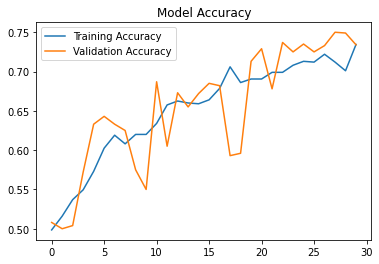

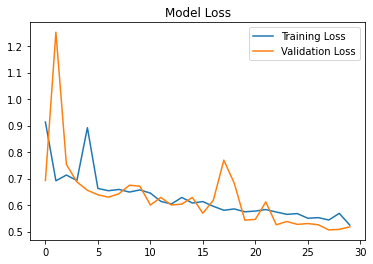

In [20]:
train_acc=history.history['acc']
val_acc=history.history['val_acc']
epochs=range(len(train_acc))
plt.plot(epochs,train_acc,label='Training Accuracy')
plt.plot(epochs,val_acc,label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.figure()

train_loss=history.history['loss']
val_loss=history.history['val_loss']
plt.plot(epochs,train_loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

## Increasing Epochs to 100

In [21]:
model4=Sequential(name='SEQ_2')
model4.add(Conv2D(16,(3,3),activation='relu',input_shape=(150,150,3),name='Layer_1_CONV'))
model4.add(MaxPool2D((2,2),name='Layer_2_MaxPool'))

model4.add(Conv2D(32,(3,3),activation='relu',name='Layer_3_CONV'))
model4.add(MaxPool2D((2,2),name='Layer_4_MaxPool'))

model4.add(Conv2D(64,(3,3),activation='relu',name='Layer_5_CONV'))
model4.add(MaxPool2D((2,2),name='Layer_6_MaxPool'))

model4.add(Conv2D(128,(3,3),activation='relu',name='Layer_7_CONV'))
model4.add(MaxPool2D((2,2),name='Layer_8_MaxPool'))

model4.add(Flatten(name='Layer_9_Flatten'))
model4.add(Dense(512,activation='relu',name='Layer_10_Dense'))
model4.add(Dense(1,activation='sigmoid',name='last_layer_Dense'))
model4.compile(optimizer=RMSprop(learning_rate=0.001),loss='binary_crossentropy',metrics=['acc'])
history=model4.fit(train_generator,steps_per_epoch=steps_per_epoch,epochs=100,validation_data=val_generator,validation_steps=validation_steps)

Epoch 1/100
20/20 [==============================] - 20s 973ms/step - loss: 0.7254 - acc: 0.5040 - val_loss: 0.6914 - val_acc: 0.5970
Epoch 2/100
20/20 [==============================] - 19s 938ms/step - loss: 0.6936 - acc: 0.5115 - val_loss: 0.6887 - val_acc: 0.5010
Epoch 3/100
20/20 [==============================] - 19s 958ms/step - loss: 0.6965 - acc: 0.5290 - val_loss: 0.6808 - val_acc: 0.6520
Epoch 4/100
20/20 [==============================] - 19s 957ms/step - loss: 0.6922 - acc: 0.5875 - val_loss: 0.6719 - val_acc: 0.5690
Epoch 5/100
20/20 [==============================] - 19s 959ms/step - loss: 0.6762 - acc: 0.5945 - val_loss: 0.6415 - val_acc: 0.6140
Epoch 6/100
20/20 [==============================] - 19s 970ms/step - loss: 0.6619 - acc: 0.6105 - val_loss: 0.6360 - val_acc: 0.6160
Epoch 7/100
20/20 [==============================] - 20s 981ms/step - loss: 0.6287 - acc: 0.6450 - val_loss: 0.5918 - val_acc: 0.6750
Epoch 8/100
20/20 [==============================] - 19s 980ms

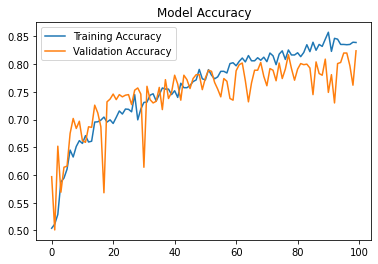

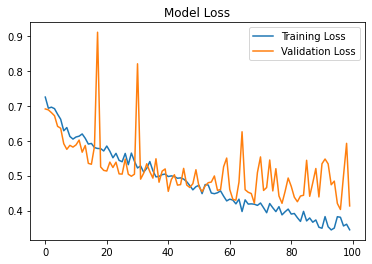

In [22]:
train_acc=history.history['acc']
val_acc=history.history['val_acc']
epochs=range(len(train_acc))
plt.plot(epochs,train_acc,label='Training Accuracy')
plt.plot(epochs,val_acc,label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.figure()

train_loss=history.history['loss']
val_loss=history.history['val_loss']
plt.plot(epochs,train_loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()